# **1. Understand Dataset**

# **2. Data Preprocessing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from google.colab import drive
import torch.optim as optim

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_dir='/content/gdrive/MyDrive/covid19_dataset/train'

# (1, 64, 64) represents 1 channel (grayscale), a height 64 pixels, and a width 64 pixels.
input_shape=(1,64,64)

transform=transforms.Compose([transforms.Resize((input_shape[1],input_shape[2])),transforms.Grayscale(), transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

train=ImageFolder(train_dir, transform=transform)

# creates a dictionary called class_id that maps class indices to class names. uses class_to_idx attribute of the train dataset object to obtain the mapping of class indices to folder names.
class_id = {v: k for k, v in train.class_to_idx.items()}

In [4]:
test_dir='/content/gdrive/MyDrive/covid19_dataset/test'

test=ImageFolder(test_dir,transform=transform)

test_id=test.class_to_idx

In [5]:
class_id

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [6]:
train[0]

(tensor([[[-0.7569, -0.7569, -0.7725,  ..., -0.7569, -0.7569, -0.7569],
          [-0.7569, -0.7647, -0.7804,  ..., -0.7647, -0.7490, -0.7569],
          [-0.7490, -0.7647, -0.7804,  ..., -0.7647, -0.7569, -0.7569],
          ...,
          [-0.7725, -0.7804, -0.7882,  ..., -0.7490, -0.7333, -0.7333],
          [-0.7725, -0.7804, -0.7882,  ..., -0.7490, -0.7412, -0.7412],
          [-0.7725, -0.7804, -0.7882,  ..., -0.7490, -0.7412, -0.7412]]]),
 0)

In [7]:
train[0][0].shape

torch.Size([1, 64, 64])

In [8]:
image,label=train[0]
label

0

In [9]:
train_loader=torch.utils.data.DataLoader(train, batch_size=24, shuffle=True)
test_loader=torch.utils.data.DataLoader(test, batch_size=24, shuffle=True)

In [10]:
# This code calculates the number of classes in your training dataset.
num_classes=[] # initializes an empty list will be used to temporarily store labels of the samples in your training dataset.

for _,labels in train:  #the underscore _ is used as a placeholder for the image data since it's not used in the loop.
  num_classes.append(labels)
num_classes=len(set(num_classes))

In [11]:
num_classes

2

torch.Size([24, 1, 64, 64])


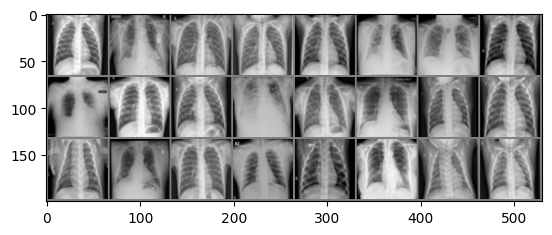

['NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL']


In [12]:
num_classes = len(set(train.targets))

def display_dataset(image):
    un_normalized_image = image / 2 + 0.5 # un-normalizes the pixel values by reversing the normalization to bring the pixel values back to the original range.
    reshaped_img = un_normalized_image.permute((1, 2, 0)) # rearranges the dimensions of the tensor to match the format
    plt.imshow(reshaped_img)
    plt.show()

dataIter = iter(train_loader)  # create an iterator from the train_loader and retrieve the first batch of images and labels.
images, labels = next(dataIter)
print(images.shape)

display_dataset(torchvision.utils.make_grid(images)) # it will stack the images in the batch horizonatally to make a grid
print([class_id[labels[j].item()] for j in range(4)]) # prints the corresponding class names

# **3. Designing the CNN**

### **3. Activation Function and Optimization Algorithm:**
Activation Function: ReLU (Rectified Linear Unit) is chosen as the activation function for the convolutional and fully connected layers. ReLU introduces non-linearity and helps in capturing complex patterns in the data.

Optimization Algorithm: Adam optimizer is used for optimization. Adam combines the advantages of both AdaGrad and RMSProp optimizers. It adapts the learning rates of each parameter and helps converge faster.

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, stride=2, kernel_size=4, padding=1), # output size is 32x32
            nn.MaxPool2d(stride=2, kernel_size=2), # output size is 16x16
            nn.PReLU(), # parametric rectified linear unit activation function. It introduces non-linearity to the network after each convolutional layer.
            nn.Conv2d(in_channels=16, out_channels=4, kernel_size=4, padding=1, stride=2), # output size is 8x8
            nn.MaxPool2d(kernel_size=2, stride=2), # output size is 4x4
            nn.PReLU()
            # ,nn.Dropout(0.5) # Adding dropout with probability of 0.5
            )
        self.fc = nn.Sequential(
            nn.Linear(in_features=4*4*4, out_features=36, bias=True), # maps the flattened input features to 36 dimensions, then to 10 dimensions, and to 2 dimensions using linear transformations.
            nn.PReLU(),  # Another PReLU activation function applied after the first linear layer.
            nn.Linear(in_features=36, out_features=10, bias=True),
            nn.ReLU(), # Rectified Linear Unit activation function applied after the second linear layer.
            nn.Linear(in_features=10, out_features=2, bias=True))

    def forward(self, data):
        data = self.conv(data)
        data = data.view(data.size(0), -1)
        data = self.fc(data)
        return data

model = CNN().to(device)
model

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(16, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): PReLU(num_parameters=1)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=36, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=36, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [25]:
criterion=nn.CrossEntropyLoss() #  The cross-entropy combines the softmax activation and the negative log likelihood loss, making it suitable for training a neural network to predict class labels.
# optim=torch.optim.SGD(model.parameters(),lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # A learning rate of 0.001 means that the optimizer adjusts the parameters by a small fraction of the computed gradient.

# **4. Training Stage**

In [19]:
epochs=30
losses=[]
acc_list=[]
for epoch in range(epochs):
  e_loss=0
  correct=0
  total=0
  for images,labels in train_loader:
    optim.zero_grad() # Clears the gradients of all optimized parameters.
    images=images.to(device) # Moves the input images and labels to the specified device (either GPU or CPU).
    labels=labels.to(device)
    outputs=model(images) # Passes the input images through the model to get predicted outputs.
    _,predictions=torch.max(outputs.data,1) # Computes the predicted class labels by finding the index of the maximum value in the output tensor.
    loss=criterion(outputs,labels) # Computes the cross-entropy loss between predicted outputs and true labels.
    loss.backward() # Computes gradients of the loss with respect to the model's parameters.
    optim.step() # Updates model parameters using the computed gradients and the optimizer.
    correct+=(predictions==labels).sum().item() # Counts the number of correct predictions in the batch.
    total+=(labels.size(0)) # Counts the total number of samples in the batch.
    e_loss+=loss.item() # Accumulates the loss for the epoch
  losses.append(e_loss/len(train_loader))
  acc_list.append(correct/total)
  print('Epoch [{}/{}]  Accuracy: {:4f}  Loss: {:.4f}'.format(epoch+1,epochs,acc_list[-1],losses[-1]))

Epoch [1/30]  Accuracy: 0.500000  Loss: 0.6937
Epoch [2/30]  Accuracy: 0.500000  Loss: 0.6907
Epoch [3/30]  Accuracy: 0.500000  Loss: 0.6960
Epoch [4/30]  Accuracy: 0.500000  Loss: 0.6956
Epoch [5/30]  Accuracy: 0.500000  Loss: 0.6926
Epoch [6/30]  Accuracy: 0.500000  Loss: 0.6905
Epoch [7/30]  Accuracy: 0.500000  Loss: 0.6926
Epoch [8/30]  Accuracy: 0.500000  Loss: 0.6918
Epoch [9/30]  Accuracy: 0.500000  Loss: 0.6919
Epoch [10/30]  Accuracy: 0.500000  Loss: 0.6938
Epoch [11/30]  Accuracy: 0.500000  Loss: 0.6915
Epoch [12/30]  Accuracy: 0.500000  Loss: 0.6932
Epoch [13/30]  Accuracy: 0.500000  Loss: 0.6910
Epoch [14/30]  Accuracy: 0.500000  Loss: 0.6909
Epoch [15/30]  Accuracy: 0.500000  Loss: 0.6920
Epoch [16/30]  Accuracy: 0.500000  Loss: 0.6916
Epoch [17/30]  Accuracy: 0.500000  Loss: 0.6903
Epoch [18/30]  Accuracy: 0.500000  Loss: 0.6892
Epoch [19/30]  Accuracy: 0.500000  Loss: 0.6883
Epoch [20/30]  Accuracy: 0.500000  Loss: 0.6915
Epoch [21/30]  Accuracy: 0.500000  Loss: 0.6904
E

Text(0, 0.5, 'Loss')

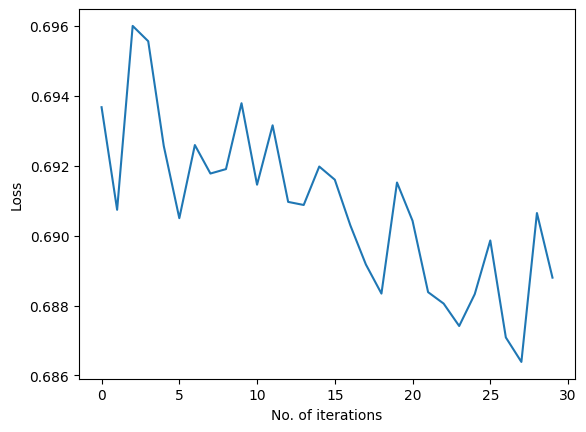

In [20]:
x=range(epochs)
plt.plot(x,losses)
plt.xlabel('No. of iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

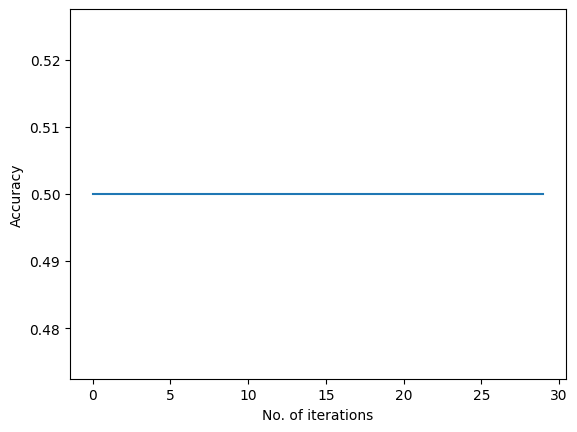

In [21]:
x=range(epochs)
plt.plot(x,acc_list)
plt.xlabel('No. of iterations')
plt.ylabel('Accuracy')

# **5. Evaluation Stage**

In [22]:
correct=0
total=0
with torch.no_grad(): # temporarily disables gradient computation, useful during inference to save memory and computation.
  for images,labels in test_loader:
    images=images.to(device) # Moves the input images and labels to the specified device (either GPU or CPU).
    labels=labels.to(device)
    outputs=model(images) # Passes the input images through the trained model to get predicted outputs.
    _,predicted=torch.max(outputs.data,1) # Computes the predicted class labels by finding the index of the maximum value in the output tensor.
    correct+=(predicted==labels).sum().item() # Counts the number of correct predictions in the batch and accumulates them.
    total+=labels.size(0) #Counts the total number of samples in the batch.
print('Accuracy score: {:.2f}%'.format(correct/total*100))

Accuracy score: 67.50%


## **EXTRA**

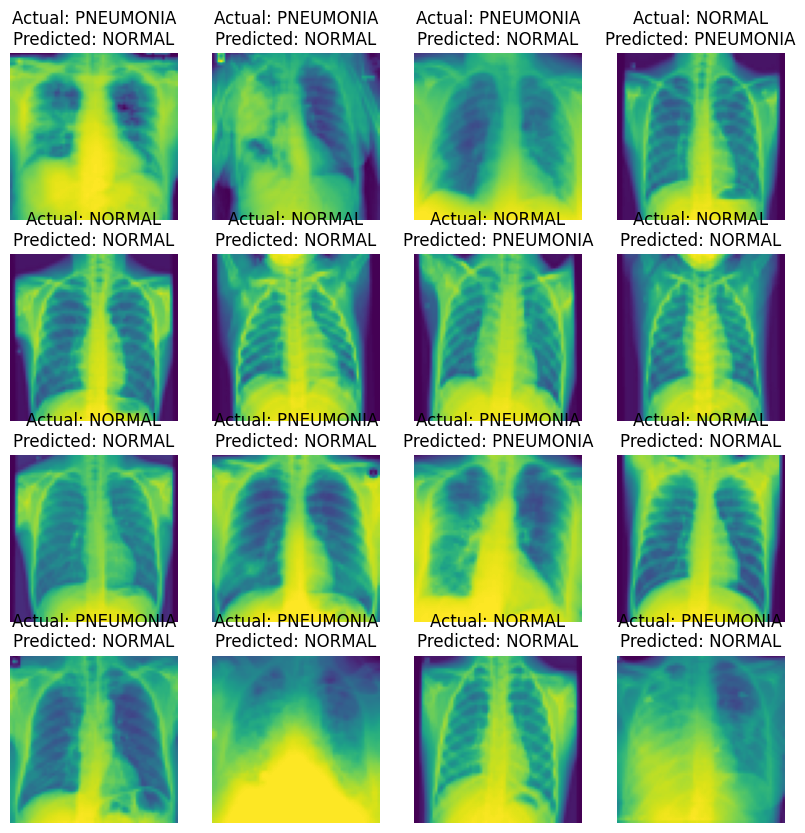

In [23]:
def show_images_predictions(images, labels, predictions):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        image = images[i] / 2 + 0.5  # Unnormalize the image
        npimg = image.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        actual_label = class_id[labels[i].item()]
        predicted_label = class_id[predictions[i].item()]
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    plt.show()

# Display a random sample of images and their actual and predicted labels
dataiter = iter(test_loader)
images, labels = next(dataiter)
show_images_predictions(images, labels, predicted)

# **6. Improvement Stage**

In [24]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=128 * 4 * 4, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, data):
        data = self.conv(data)
        data = data.view(data.size(0), -1)
        data = self.fc(data)
        return data

model = ImprovedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)